# Dynamic Linear Model

In [1]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile
from pyro.infer.autoguide import AutoNormal, AutoDelta, AutoDiagonalNormal

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



## Data

In [2]:
# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)

# convert to torch tensors
X_W = torch.from_numpy(dfW.values).float()
X_E = torch.from_numpy(dfE.values).float()
obs = torch.from_numpy(df["price actual"].values).float()


# translate to pyro forecasting language
T = None # number of time steps to include, if None all data is used
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting

# start, train end, test end
T0 = 0
T1 = n - n//10 # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

In [4]:
class VanillaDLM(ForecastingModel):
    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]


        # drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))

        h_dim = 8
        M = 5
        tau = 1
        gamma = 1
        lambda_g = 1
        lambda_f = 1
        sigma_beta = 1

        with pyro.plate("seasons", M):
            # define the model
            sigma = pyro.sample("sigma", dist.HalfCauchy(tau))
            R = pyro.sample("R", dist.HalfCauchy(gamma*torch.ones(h_dim)).to_event()) 
            theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(h_dim), lambda_g*torch.ones(h_dim)).to_event())
            f_dim = h_dim, X_E.shape[1] + X_W.shape[1] + h_dim
            theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros(f_dim), lambda_f*torch.ones(f_dim)).to_event())
            # beta = pyro.sample("beta", dist.Normal(0, sigma_beta), sample_shape=(X_W.shape[1],))
            beta = pyro.sample("beta", dist.Normal(torch.zeros(x_W.shape[1],), sigma_beta*torch.ones(x_W.shape[1],)).to_event())


        with self.time_plate:
            # with poutine.reparam(config={"drift": LocScaleReparam()}):
            #     drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
            # print(x_W.shape, beta.shape)
            z = pyro.sample("z", dist.Categorical(logits = x_W @beta.T), infer={"enumerate": "parallel"},)#.to_event(1))
        
        pyro.deterministic("season", z)

        h = pyro.sample("h_0", dist.Normal(torch.zeros(h_dim), torch.ones(h_dim)))
        x = torch.zeros(duration+1, *h.shape)
        x[0] = h

        # R = R.permute(1, 0)
        # theta_g = theta_g.permute(1, 0)
        # print("theta_f: ", theta_f.shape)
        # theta_f = theta_f.permute(2, 1, 0)

        # weight = drift.cumsum(-2)  # A Brownian motion.
        # # record in model_trace
        # pyro.deterministic("weight", weight)

        # prediction = (weight * covariates).sum(-1, keepdim=True)

        pred_plate = pyro.plate("pred_plate", data_dim, dim=-1)
        preds = torch.zeros(duration)
        for t in tqdm(pyro.markov(range(duration)), total=duration):
            # print(h)
            # Draw season variable zt ∼ Multinomial(zt |Softmax(XtW , β1 , . . . , βM ))
            # print(x_E[t].shape, x_W[t].shape, h.shape)
            c = torch.concat((x_E[t], x_W[t], h)).unsqueeze(1)

            # print(theta_f[z[t]].shape, c.shape, theta_f.shape)
            # print(theta_f[z[t]], c)
            h_mean = (theta_f[z[t]] @ c).squeeze()
            # h_mean = (h_mean - h_mean.mean(0, keepdim=True)) / h_mean.std(0, keepdim=True)
            # print(h_mean)
            h_var = R[z[t]]
            # print("mean+var: ",h_mean.shape, h_var.shape, h_mean.mean(), h_var.mean())
            h = pyro.sample(f"h_{t+1}", dist.Normal(h_mean, h_var))#, infer={"enumerate": "parallel"})
            h = h.squeeze(-1)
            # x[t+1]
            # prediction[t] = 

            with pred_plate:
                preds[t] = pyro.sample(f"y_{t+1}", dist.Normal(theta_g[z[t]] @ h, sigma[z[t]]))
        # x = x[:-1]
        # print(theta_g.shape, theta_g[z].shape, x.shape, z.shape)
        # prediction = theta_g[z] @ x
        prediction = preds.unsqueeze(-1)
        assert prediction.shape[-2:] == zero_data.shape, f"{prediction.shape}, {zero_data.shape}"
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        # scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, 1)

        self.predict(noise_dist, prediction)

## Inference

In [5]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()

model = VanillaDLM()
# guide = AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)]))
guide = AutoNormal(poutine.block(model, hide="z"))

forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=300,
    guide = guide
)

100%|██████████| 1315/1315 [00:01<00:00, 1199.39it/s]


TypeError: 'in <string>' requires string as left operand, not NoneType

In [5]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


## Analyze posterior samples

In [6]:
posterior_samples.keys()

dict_keys(['particles', 'time', 'drift_scale', 'drift_decentered', 'drift', 'weight', 'prediction', 'noise_scale', 'residual'])

In [7]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

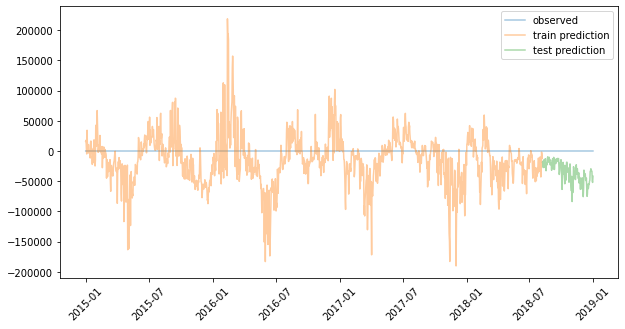

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# dates = df.time_str.values

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()